In [75]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [76]:
img = cv2.imread('/content/drive/MyDrive/500px-Fourier2(1).jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

R = img_rgb[:,:,0]
G = img_rgb[:,:,1]
B = img_rgb[:,:,2]

RG = np.stack((R, G, np.zeros_like(B)), axis=-1)
GB = np.stack((np.zeros_like(R), G, B), axis=-1)
RB = np.stack((R, np.zeros_like(G), B), axis=-1)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

array([[249, 251, 253, ..., 253, 252, 253],
       [250, 251, 252, ..., 251, 250, 251],
       [250, 251, 252, ..., 250, 249, 250],
       ...,
       [219, 218, 234, ..., 224, 232, 224],
       [235, 240, 223, ..., 216, 225, 218],
       [226, 223, 222, ..., 221, 234, 231]], dtype=uint8)
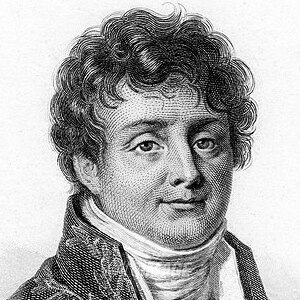

In [77]:
gray

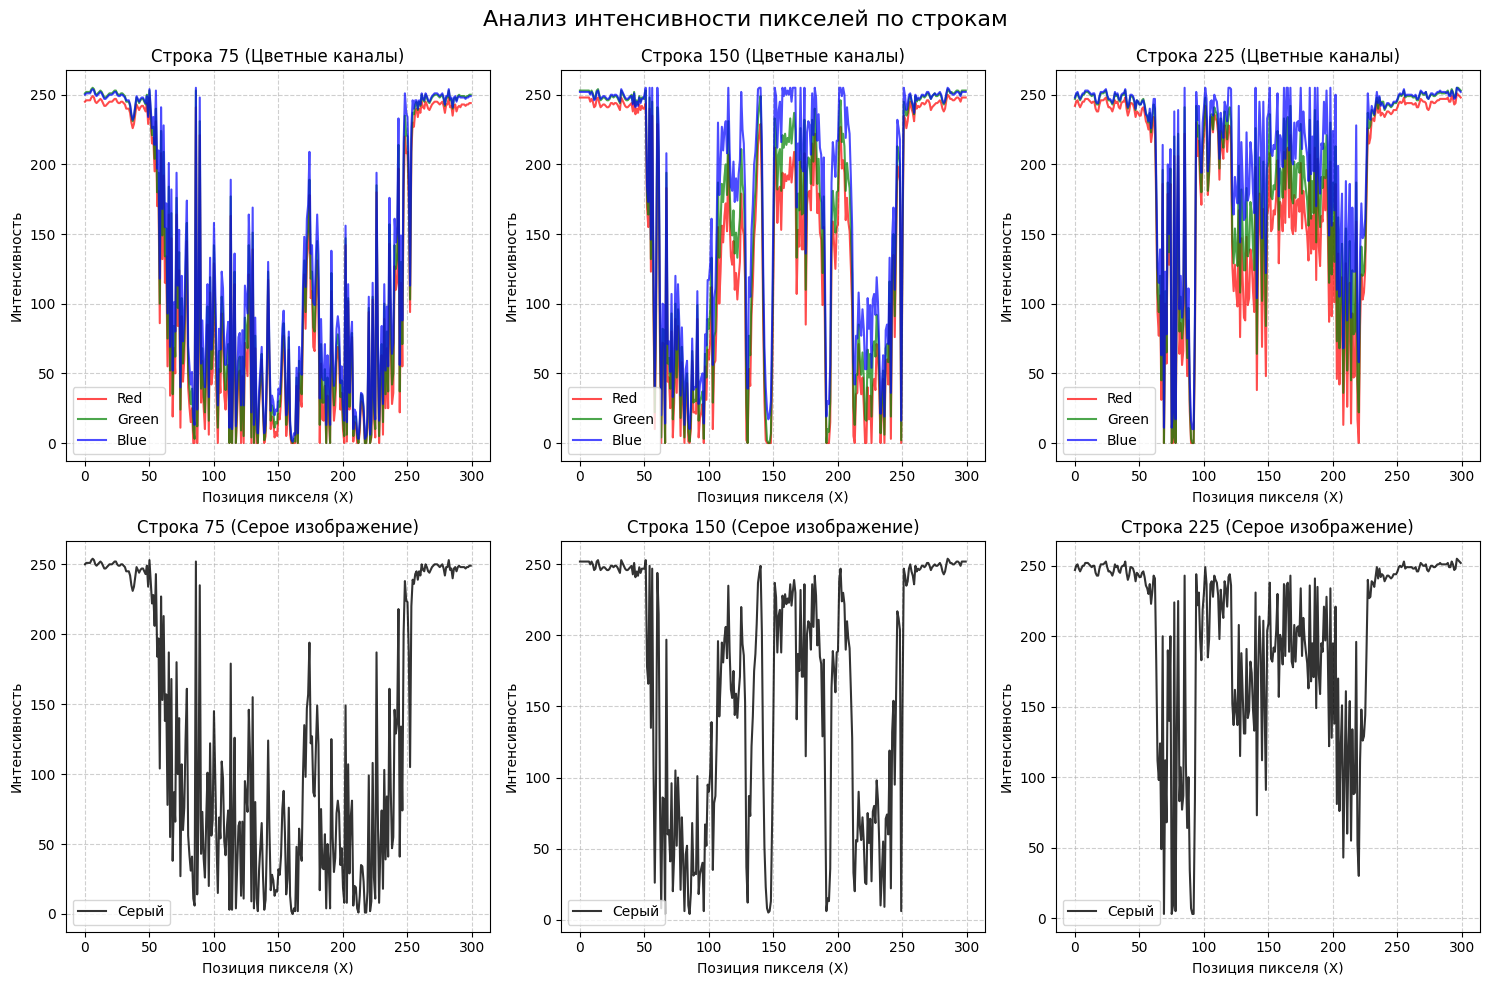

In [78]:
height = img.shape[0]
selected_rows = [
    height // 4,
    height // 2,
    3 * height // 4
]

fig, axes = plt.subplots(2, len(selected_rows), figsize=(15, 10))
fig.suptitle('Анализ интенсивности пикселей по строкам', fontsize=16)

for i, row in enumerate(selected_rows):
    # цветное
    axes[0, i].plot(img[row, :, 0], 'r-', label='Red', alpha=0.7)
    axes[0, i].plot(img[row, :, 1], 'g-', label='Green', alpha=0.7)
    axes[0, i].plot(img[row, :, 2], 'b-', label='Blue', alpha=0.7)
    axes[0, i].set_title(f'Строка {row} (Цветные каналы)')
    axes[0, i].set_xlabel('Позиция пикселя (X)')
    axes[0, i].set_ylabel('Интенсивность')
    axes[0, i].legend()
    axes[0, i].grid(True, linestyle='--', alpha=0.6)

    # серое
    axes[1, i].plot(gray[row, :], 'k-', label='Серый', alpha=0.8)
    axes[1, i].set_title(f'Строка {row} (Серое изображение)')
    axes[1, i].set_xlabel('Позиция пикселя (X)')
    axes[1, i].set_ylabel('Интенсивность')
    axes[1, i].legend()
    axes[1, i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [79]:
class ImageFilter:
    def __init__(self, image):
        self.image = image
        self.height, self.width = image.shape[:2]

    def _apply_convolution(self, kernel, padding='reflect'):
        k_height, k_width = kernel.shape
        pad_y = k_height // 2
        pad_x = k_width // 2

        if len(self.image.shape) == 3:
            channels = []
            for c in range(3):
                channel = self._convolve_channel(self.image[:, :, c], kernel, pad_y, pad_x, padding)
                channels.append(channel)
            return np.stack(channels, axis=2)
        else:
            return self._convolve_channel(self.image, kernel, pad_y, pad_x, padding)

    def _convolve_channel(self, channel, kernel, pad_y, pad_x, padding):
        padded = self._apply_padding(channel, pad_y, pad_x, padding)
        result = np.zeros((self.height, self.width))
        for y in range(self.height):
            for x in range(self.width):
                region = padded[y:y+2*pad_y+1, x:x+2*pad_x+1]
                result[y, x] = np.sum(region * kernel)
        return np.clip(result, 0, 255).astype(np.uint8)

    def _apply_padding(self, img, pad_y, pad_x, mode):
        if mode == 'reflect':
            return np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), 'reflect')
        elif mode == 'edge':
            return np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), 'edge')
        elif mode == 'constant':
            return np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), 'constant')
        elif mode == 'wrap':
            return np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), 'wrap')
        else:
            return np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), 'reflect')

    def apply_threshold(self, threshold=128):
        if len(self.image.shape) == 3:
            gray = np.dot(self.image[..., :3], [0.299, 0.587, 0.114])
        else:
            gray = self.image.copy()

        return np.where(gray > threshold, 255, 0).astype(np.uint8)

    def apply_median(self, kernel_size=3):
        if kernel_size % 2 == 0:
            kernel_size += 1

        pad = kernel_size // 2
        result = np.zeros_like(self.image)

        if len(self.image.shape) == 3:
            for c in range(3):
                padded = self._apply_padding(self.image[:, :, c], pad, pad, 'reflect')
                for y in range(self.height):
                    for x in range(self.width):
                        window = padded[y:y+kernel_size, x:x+kernel_size]
                        result[y, x, c] = np.median(window)
            return result
        else:
            padded = self._apply_padding(self.image, pad, pad, 'reflect')
            for y in range(self.height):
                for x in range(self.width):
                    window = padded[y:y+kernel_size, x:x+kernel_size]
                    result[y, x] = np.median(window)
            return result

    def gaussian_kernel(self, size=5, sigma=1.0):
        """Генерация ядра Гаусса"""
        kernel = np.zeros((size, size))
        k = size // 2

        for i in range(-k, k+1):
            for j in range(-k, k+1):
                kernel[i+k, j+k] = np.exp(-(i**2 + j**2)/(2*sigma**2))

        return kernel / np.sum(kernel)

    def apply_gaussian(self, kernel_size=5, sigma=1.0):
        kernel = self.gaussian_kernel(kernel_size, sigma)
        return self._apply_convolution(kernel)

    def apply_box_blur(self, kernel_size=3):
        kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
        return self._apply_convolution(kernel)

    def apply_sobel(self):

        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

        if len(self.image.shape) == 3:
            gray = np.dot(self.image[..., :3], [0.299, 0.587, 0.114])
        else:
            gray = self.image.copy()

        gx = self._apply_convolution(sobel_x)
        gy = self._apply_convolution(sobel_y)

        magnitude = np.sqrt(gx.astype(float)**2 + gy.astype(float)**2)
        return (magnitude / magnitude.max() * 255).astype(np.uint8)

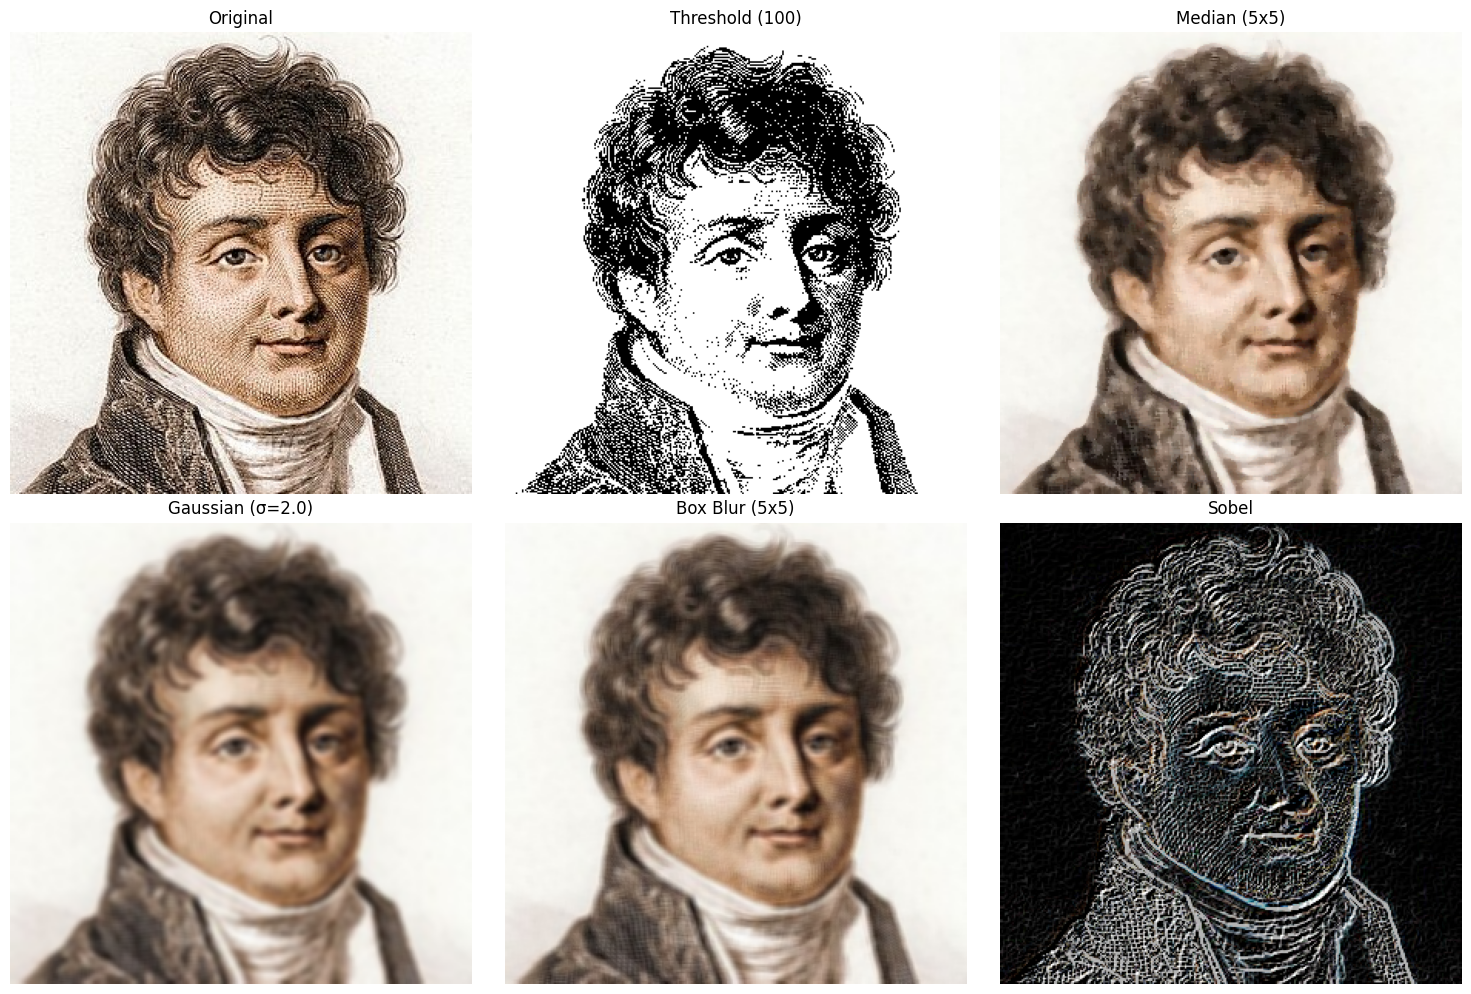

In [80]:
img_filter = ImageFilter(img)

results = {
    "Original": img,
    "Threshold (100)": img_filter.apply_threshold(100),
    "Median (5x5)": img_filter.apply_median(5),
    "Gaussian (σ=2.0)": img_filter.apply_gaussian(7, 2.0),
    "Box Blur (5x5)": img_filter.apply_box_blur(5),
    "Sobel": img_filter.apply_sobel()
}

plt.figure(figsize=(15, 10))

for i, (title, img) in enumerate(results.items(), 1):
    plt.subplot(2, 3, i)
    if len(img.shape) == 2 or img.shape[2] == 1:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [81]:


def fourier_zoom(image, scale_factor, m=None, n=None, a=0.0, t=0.0):
    h, w = image.shape
    if m is None: m = min(100, w)
    if n is None: n = min(100, h)

    dct_coeffs = cv2.dct(image.astype(np.float32))

    if a > 0 and t > 0:
        # Создаем частотную сетку
        j = np.arange(0, w).reshape(1, -1)
        k = np.arange(0, h).reshape(-1, 1)

        lambda_jk = (np.pi * j / w)**2 + (np.pi * k / h)**2

        dct_coeffs *= np.exp(-a**2 * lambda_jk * t)

    dct_truncated = np.zeros_like(dct_coeffs)
    n_clip = min(n, h)
    m_clip = min(m, w)
    dct_truncated[:n_clip, :m_clip] = dct_coeffs[:n_clip, :m_clip]

    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    dct_zoomed = np.zeros((new_h, new_w), dtype=np.float32)


    n_zoom = min(n, new_h)
    m_zoom = min(m, new_w)
    dct_zoomed[:n_zoom, :m_zoom] = dct_truncated[:n_zoom, :m_zoom]

    zoomed = cv2.idct(dct_zoomed)

    zoomed = np.clip(zoomed, 0, 255).astype(np.uint8)
    return zoomed

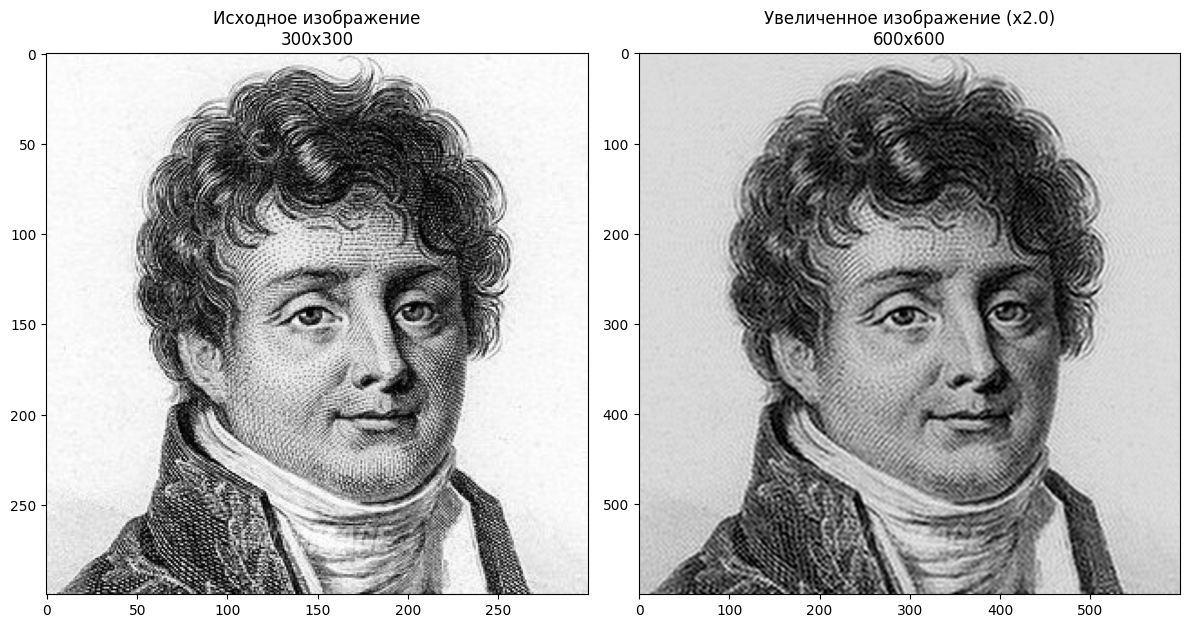

In [82]:
scale_factor = 2.0
m_harmonics = 200
n_harmonics = 200
smooth_params = (0.01, 7)

zoomed_img = fourier_zoom(
    gray,
    scale_factor,
    m=m_harmonics,
    n=n_harmonics,
    a = smooth_params[0], t = smooth_params[1]
)


cv2.imwrite("fourier_zoom.jpg", zoomed_img )

# Визуализация
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title(f"Исходное изображение\n{gray.shape[0]}x{gray.shape[1]}")

plt.subplot(122)
plt.imshow(zoomed_img, cmap='gray')
plt.title(f"Увеличенное изображение (x{scale_factor})\n{zoomed_img.shape[1]}x{zoomed_img.shape[0]}")

plt.tight_layout()
plt.savefig("comparison.png", dpi=200)
plt.show()


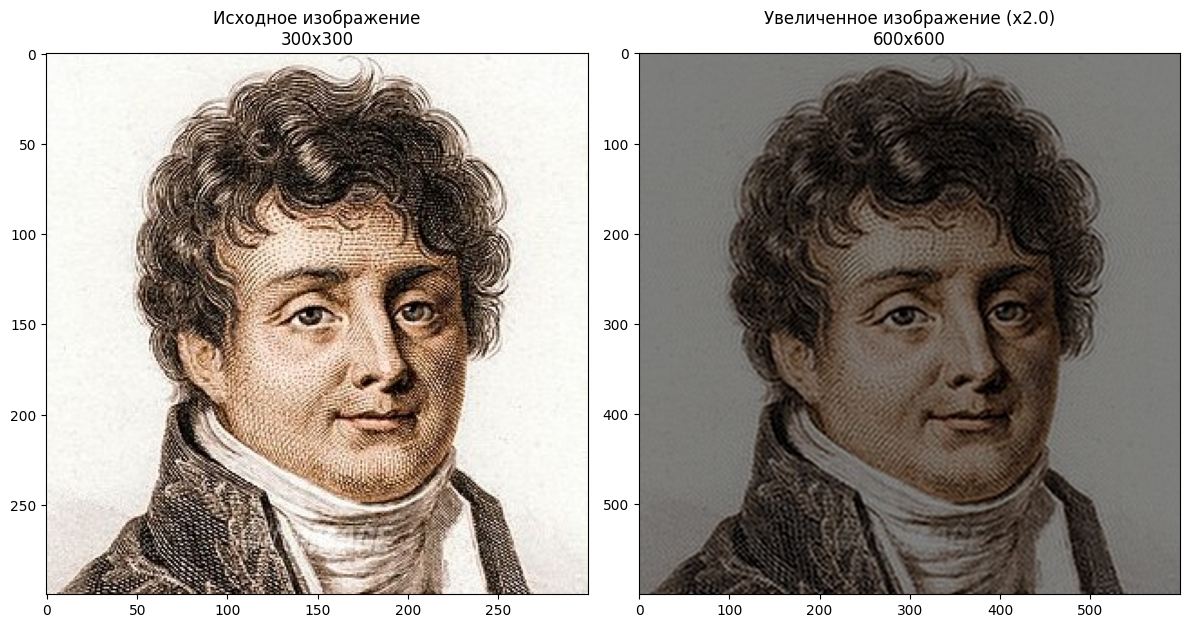

In [84]:
b_zoom = fourier_zoom(B, scale_factor, m=200, n=200,  a = 0.01, t = 7)
g_zoom = fourier_zoom(G, scale_factor, m=200, n=200,  a =0.01, t = 7)
r_zoom = fourier_zoom(R, scale_factor, m=200, n=200,  a =0.01, t = 7)

result = cv2.merge([ r_zoom, g_zoom, b_zoom,])

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img_rgb)
plt.title(f"Исходное изображение\n{img_rgb.shape[0]}x{img_rgb.shape[1]}")

plt.subplot(122)
plt.imshow(result)
plt.title(f"Увеличенное изображение (x{scale_factor})\n{result.shape[1]}x{result.shape[0]}")

plt.tight_layout()
plt.savefig("comparison.png", dpi=200)
plt.show()